#            **COMPARATIVE ANALYSIS OF NAÏVE BAYES  CLASSIFIERS ON UCI HAR DATA**

#Importing Libraries

In [2]:
# Importing Libraries
import numpy as np  # Importing numpy library for numerical operations
import pandas as pd  # Importing pandas library for data manipulation and analysis
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV  # Importing functions for splitting data, cross-validation, and hyperparameter tuning

from sklearn.impute import SimpleImputer  # For handling missing values
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # For scaling and one-hot encoding
from sklearn.feature_selection import SelectKBest, f_classif  # For feature selection
from sklearn.ensemble import IsolationForest  # For outlier detection and removal
from sklearn.decomposition import PCA  # For dimensionality reduction
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.naive_bayes import GaussianNB  # Importing Gaussian Naive Bayes classifier
from sklearn.ensemble import RandomForestClassifier  # Importing Random Forest classifier
from sklearn.tree import DecisionTreeClassifier  # Importing Decision Tree classifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Importing functions for model evaluation
import matplotlib.pyplot as plt  # Importing matplotlib for plotting
import seaborn as sns  # Importing seaborn for enhanced visualization

#Import Drive

In [3]:
# Importing the drive module from google.colab
from google.colab import drive

# Mounting Google Drive onto the Colab environment
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the DATA

In [4]:
# Load the column names
column_names = pd.read_csv('/content/drive/MyDrive/UCI HAR Dataset/features.txt', sep = "\s+", header = None)[1].values

# Load the datasets
X_train = pd.read_csv('/content/drive/MyDrive/UCI HAR Dataset/train/X_train.txt', delim_whitespace = True, header = None)
y_train = pd.read_csv('/content/drive/MyDrive/UCI HAR Dataset/train/y_train.txt', delim_whitespace = True, header = None, names = ['Activity'])
X_test = pd.read_csv('/content/drive/MyDrive/UCI HAR Dataset/test/X_test.txt', delim_whitespace = True, header = None)
y_test = pd.read_csv('/content/drive/MyDrive/UCI HAR Dataset/test/y_test.txt', delim_whitespace = True, header = None, names = ['Activity'])

# Rename columns with unique names
X_train.columns = column_names
X_test.columns = column_names

# DATA PREPROCESSING

In [5]:
# Data preprocessing
# Handle missing values in-place
imputer = SimpleImputer(strategy = 'mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scale features in-place
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Feature selection
selector = SelectKBest(score_func = f_classif, k = 50)
X_train_selected = selector.fit_transform(X_train_scaled, y_train.values.ravel())
X_test_selected = selector.transform(X_test_scaled)

# One-hot encoding (converting to dense array to save memory)
encoder = OneHotEncoder(sparse_output = False)
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

# Outlier detection and removal (detecting outliers in-place)
outlier_detector = IsolationForest()
outliers_train = outlier_detector.fit_predict(X_train_scaled)
X_train_no_outliers = X_train_scaled[outliers_train == 1]

# Dimensionality reduction
pca = PCA(n_components = 0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Data augmentation
augmentor = SMOTE()
X_train_augmented, y_train_augmented = augmentor.fit_resample(X_train_selected, y_train_encoded)


# NAIVE BAYES CLASSIFIER

## Training & Mean Accuracy Evaluation

In [6]:
# Train Naive Bayes Classifier
nb_classifier = GaussianNB()
nb_accuracy = np.mean(cross_val_score(nb_classifier, X_train, y_train.values.ravel(), cv = 5))
print("Naive Bayes Classifier Mean Accuracy (Cross-Validation):", nb_accuracy)

Naive Bayes Classifier Mean Accuracy (Cross-Validation): 0.6862267789508734


## Prediction and Evaluation

In [7]:
# Predict and evaluate Naive Bayes Classifier on test set
nb_classifier.fit(X_train, y_train.values.ravel())
nb_pred = nb_classifier.predict(X_test)
nb_test_accuracy = accuracy_score(y_test, nb_pred)
print("Naive Bayes Classifier Accuracy on Test Set:", nb_test_accuracy)
print("Classification Report for Naive Bayes Classifier:")
print(classification_report(y_test, nb_pred))

Naive Bayes Classifier Accuracy on Test Set: 0.7702748557855447
Classification Report for Naive Bayes Classifier:
              precision    recall  f1-score   support

           1       0.82      0.84      0.83       496
           2       0.76      0.96      0.84       471
           3       0.83      0.61      0.70       420
           4       0.58      0.75      0.65       491
           5       0.80      0.86      0.83       532
           6       0.96      0.60      0.74       537

    accuracy                           0.77      2947
   macro avg       0.79      0.77      0.77      2947
weighted avg       0.79      0.77      0.77      2947



## Confusion Matrix

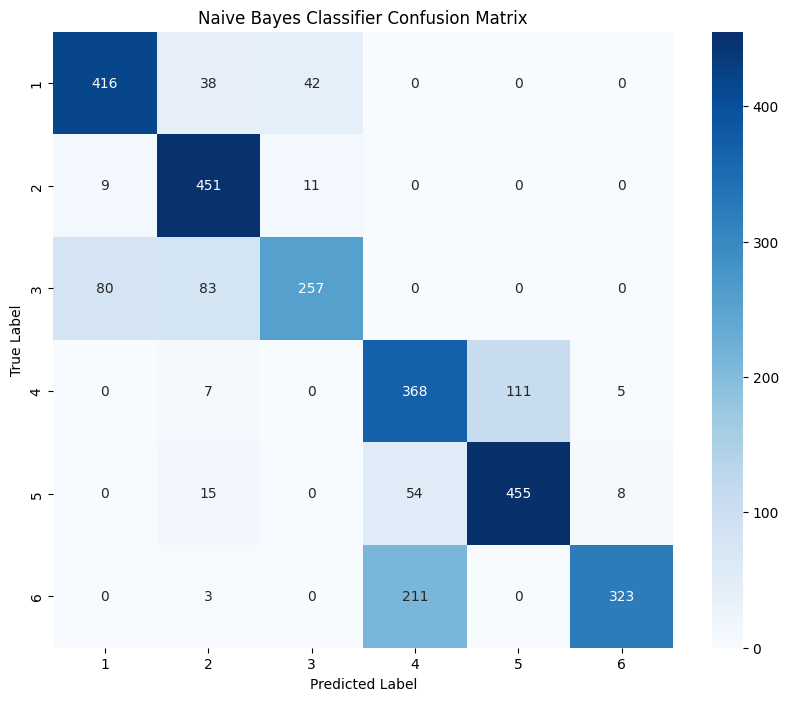

In [8]:
# Plot confusion matrix for Naive Bayes Classifier
nb_cm = confusion_matrix(y_test, nb_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(nb_cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = np.unique(y_test), yticklabels = np.unique(y_test))
plt.title('Naive Bayes Classifier Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# DECISION TREE CLASSIFIER

## Training

In [9]:
# Train Decision Tree Classifier with hyperparameter tuning
param_grid_dt = {'max_depth': np.arange(1, 10)}
dt_classifier = DecisionTreeClassifier()
dt_grid_search = GridSearchCV(dt_classifier, param_grid_dt, cv = 5)
dt_grid_search.fit(X_train, y_train.values.ravel())
dt_best_classifier = dt_grid_search.best_estimator_

## Mean Accuracy Evaluation

In [10]:
# Evaluate Decision Tree Classifier
dt_accuracy = np.mean(cross_val_score(dt_best_classifier, X_train, y_train.values.ravel(), cv = 5))
print("Decision Tree Classifier Mean Accuracy (Cross-Validation):", dt_accuracy)

Decision Tree Classifier Mean Accuracy (Cross-Validation): 0.8562371842006687


## Prediction and Evaluation

In [11]:
# Predict and evaluate Decision Tree Classifier on test set
dt_pred = dt_best_classifier.predict(X_test)
dt_test_accuracy = accuracy_score(y_test, dt_pred)
print("\nDecision Tree Classifier Accuracy on Test Set:", dt_test_accuracy)
print("Classification Report for Decision Tree Classifier:")
print(classification_report(y_test, dt_pred))


Decision Tree Classifier Accuracy on Test Set: 0.8720732948761453
Classification Report for Decision Tree Classifier:
              precision    recall  f1-score   support

           1       0.83      0.95      0.89       496
           2       0.85      0.78      0.81       471
           3       0.90      0.83      0.86       420
           4       0.87      0.76      0.81       491
           5       0.80      0.89      0.84       532
           6       1.00      1.00      1.00       537

    accuracy                           0.87      2947
   macro avg       0.87      0.87      0.87      2947
weighted avg       0.87      0.87      0.87      2947



## Confusion Matrix

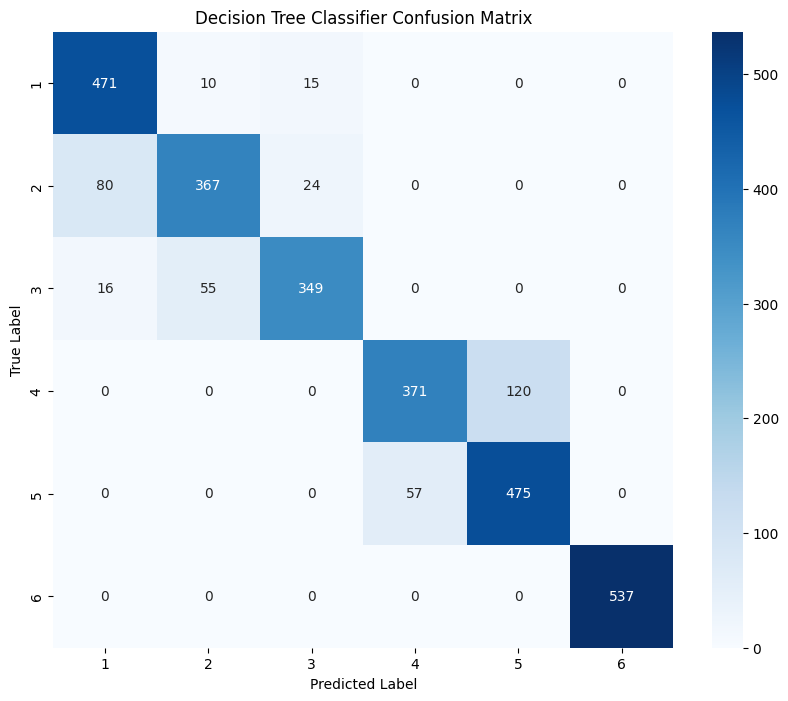

In [12]:
# Plot confusion matrix for Decision Tree Classifier
dt_cm = confusion_matrix(y_test, dt_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(dt_cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = np.unique(y_test), yticklabels = np.unique(y_test))
plt.title('Decision Tree Classifier Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# RANDOM FOREST CLASSIFIER

## Training The Data

In [18]:
# Train Random Forest Classifier with hyperparameter tuning
param_grid_rf = {'n_estimators': [50, 100, 150], 'max_depth': [3, 5, 7]}
rf_classifier = RandomForestClassifier()
rf_grid_search = GridSearchCV(rf_classifier, param_grid_rf, cv = 5)
rf_grid_search.fit(X_train, y_train.values.ravel())
rf_best_classifier = rf_grid_search.best_estimator_

## Mean Accuracy Evaluation

In [19]:
# Evaluate Random Forest Classifier
rf_accuracy = np.mean(cross_val_score(rf_best_classifier, X_train, y_train.values.ravel(), cv = 5))
print("Random Forest Classifier Mean Accuracy (Cross-Validation):", rf_accuracy)

Random Forest Classifier Mean Accuracy (Cross-Validation): 0.9151286782558026


## Prediction and Evaluation

In [28]:
# Predict and evaluate Random Forest Classifier on test set
rf_pred = rf_best_classifier.predict(X_test)
rf_test_accuracy = accuracy_score(y_test, rf_pred)
print("\nRandom Forest Classifier Accuracy on Test Set:", rf_test_accuracy)
print("Classification Report for Random Forest Classifier:")
print(classification_report(y_test, rf_pred))


Random Forest Classifier Accuracy on Test Set: 0.9134713267729895
Classification Report for Random Forest Classifier:
              precision    recall  f1-score   support

           1       0.87      0.97      0.92       496
           2       0.90      0.91      0.91       471
           3       0.95      0.80      0.87       420
           4       0.92      0.84      0.88       491
           5       0.86      0.93      0.89       532
           6       1.00      1.00      1.00       537

    accuracy                           0.91      2947
   macro avg       0.92      0.91      0.91      2947
weighted avg       0.92      0.91      0.91      2947



## Confusion Matrix

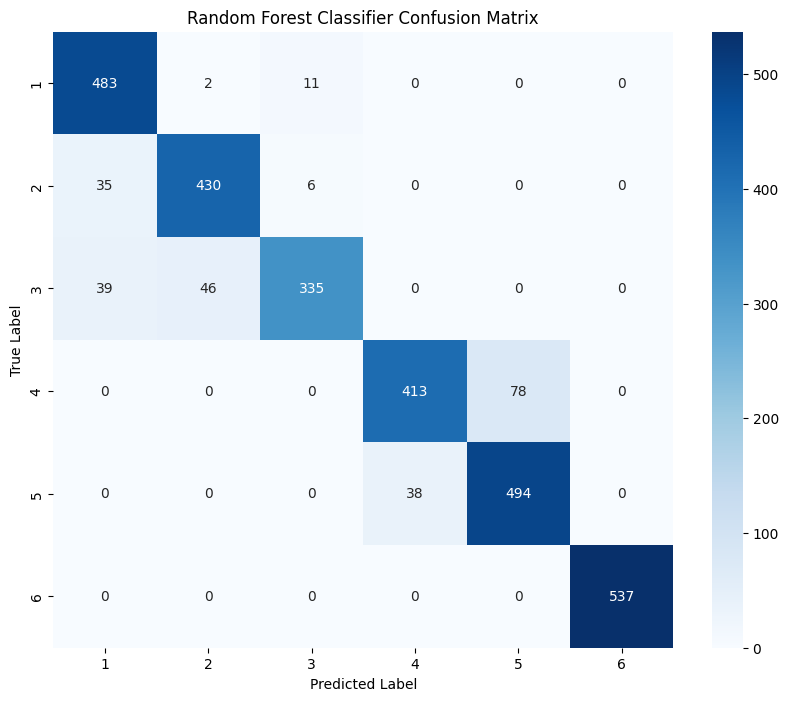

In [29]:
# Plot confusion matrix for Random Forest Classifier
rf_cm = confusion_matrix(y_test, rf_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(rf_cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = np.unique(y_test), yticklabels = np.unique(y_test))
plt.title('Random Forest Classifier Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# COMPARISION

In [30]:
# Compare accuracies
classifiers = ['Naive Bayes', 'Decision Tree', 'Random Forest']
accuracies = [nb_accuracy, dt_accuracy, rf_accuracy]

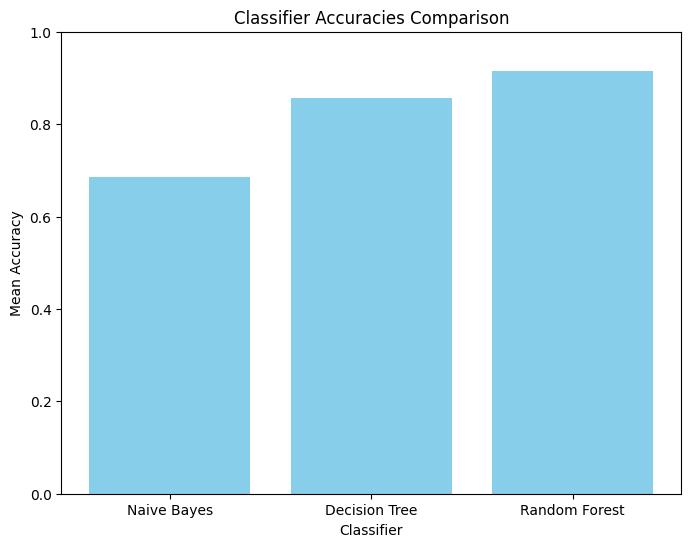

In [31]:
# Plot accuracies as a bar plot
plt.figure(figsize = (8, 6))
plt.bar(classifiers, accuracies, color = 'skyblue')
plt.title('Classifier Accuracies Comparison')
plt.xlabel('Classifier')
plt.ylabel('Mean Accuracy')
plt.ylim(0, 1)
plt.show()

# OVERALL ACCURACIES

In [32]:
# Print accuracies
for classifier, accuracy in zip(classifiers, accuracies):
    print(f'{classifier} Classifier Mean Accuracy: {accuracy * 100:.2f}%')

Naive Bayes Classifier Mean Accuracy: 68.62%
Decision Tree Classifier Mean Accuracy: 85.62%
Random Forest Classifier Mean Accuracy: 91.51%
